# Data Source
https://intl-atlas-downloads.s3.amazonaws.com/index.html
2017年全球的进出口额

这个数据没有空值,空值完全用0来代替

In [20]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import pickle
from ECI import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
def get_dict(lst):
    return dict(zip(list(set(lst)),range(len(set(lst)))))

In [139]:
df_gdp = pd.read_csv('./API_NY.GDP.PCAP.CD_DS2_en_csv_v2_41089.csv', sep = ',')
df_g = df_gdp[['Country Name', 'Country Code', '2017']]
df_g.head()

,Country Name,Country Code,2017
0,Aruba,ABW,25630.266492
1,Afghanistan,AFG,556.302139
2,Angola,AGO,4095.812942
3,Albania,ALB,4532.889198
4,Andorra,AND,39134.393371


In [143]:
gdp = dict(zip(list(df_g['Country Code']),list(df_g['2017'])))

In [18]:
locationDf = pd.read_csv('location.csv',low_memory=False)
locationDf.head()

,location_id,location_code,location_name_short_en
0,0,ABW,Aruba
1,1,AFG,Afghanistan
2,2,AGO,Angola
3,3,AIA,Anguilla
4,4,ALB,Albania


In [144]:
countryid2code=dict(zip(list(locationDf['location_id']),list(locationDf['location_code'])))

In [19]:
productDf = pd.read_csv('sitc_product.csv',low_memory=False)
productDf.head()

,product_id,sitc_product_code,sitc_product_name_short_en
0,0,0,Food
1,1,1,Beverages
2,2,2,Crude materials
3,3,3,Fuels
4,4,4,Vegetable oils


In [145]:
productid2name = dict(zip(list(productDf['product_id']),list(productDf['sitc_product_name_short_en'])))

In [20]:
Df = pd.read_csv('./country_partner_hsproduct4digit_year_2017.csv',low_memory=False)
#Df.columns[Df.isna().any()].tolist()
Df.head()

,location_id,partner_id,product_id,year,export_value,import_value,hs_eci,hs_coi,location_code,location_name_short_en,partner_code,partner_name_short_en,hs_product_code,hs_product_name_short_en
0,0,7,696,2017,0,258,0.765665,-0.051233,ABW,Aruba,ARE,United Arab Emirates,0603,Cut flowers
1,14,7,696,2017,133793,0,-0.475236,-0.207547,AUS,Australia,ARE,United Arab Emirates,0603,Cut flowers
2,16,7,696,2017,0,13512,-0.853249,-1.090533,AZE,Azerbaijan,ARE,United Arab Emirates,0603,Cut flowers
3,18,7,696,2017,4775,0,1.201220,1.282452,BEL,Belgium,ARE,United Arab Emirates,0603,Cut flowers
4,24,7,696,2017,0,13675,0.270925,-0.578558,BHR,Bahrain,ARE,United Arab Emirates,0603,Cut flowers


In [207]:
productid2name = dict(zip(list(Df["product_id"]),list(Df['hs_product_name_short_en'])))

In [246]:
countryid2name = dict(zip(list(Df["location_id"]),list(Df['location_code'])))

# 构建国家-产品矩阵

In [24]:
XYZ = [[Df.location_id[i],Df.product_id[i],Df.export_value[i]] for i in Df.index if Df.export_value[i]>0]

In [98]:
X = [x for x,y,z in XYZ]
Y = [y for x,y,z in XYZ]
Z = [z*1.0 for x,y,z in XYZ]

In [65]:
dx = get_dict(X)
dy = get_dict(Y)

In [230]:
y2origin={dy[key]:key for key in dy}
x2origin={dx[key]:key for key in dx}

In [66]:
x = [dx[i] for i in X]
y = [dy[i] for i in Y]

In [99]:
from scipy import sparse
import copy 
nx,ny=len(dx),len(dy)
M = sparse.csc_matrix((Z,(x,y)),shape=(nx,ny))
M = RCA_sparse(M)
M0 = M.T*M
M1 = M0 / M0.sum(axis=0)
M2=np.zeros((len(M1),len(M1)))
M3=copy.deepcopy(M1)
for k in range(2,10):
    M3 = M3*M1
    M2+=M3
M2=M2 / M2.sum(axis=0)
Md = M0.todok()
index = list(dict(Md).keys())

In [280]:
x=[M1[i,j] for (i,j) in index]
y=[M2[i,j] for (i,j) in index]

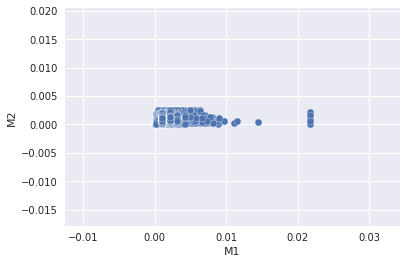

In [281]:
sns.set()
plt.scatter(x,y,edgecolor='w')
plt.ylabel("M2")
plt.xlabel("M1")
plt.show()

In [284]:
K = [[i,j,M1[i,j]/M2[i,j]] for (i,j) in index]
SW = sorted(K,key=lambda x:x[2],reverse=True)
tmp =[]
for i,j,k in SW[:10]:
    try:
        tmp.append([productid2name[y2origin[i]],productid2name[y2origin[j]],k])
    except:
        pass
pd.DataFrame(tmp)

,0,1,2
0,"Fulminates, cyanates and thiocyanates","Fulminates, cyanates and thiocyanates",237.209791
1,"Fulminates, cyanates and thiocyanates",Endless bands of copper wire for machinery,137.146764
2,Endless bands of copper wire for machinery,"Fulminates, cyanates and thiocyanates",137.146764
3,Asbestos,Asbestos,74.877670
4,Tin ore,Tin ore,65.331323
5,Ferrous products from the reduction of iron ore,"Fulminates, cyanates and thiocyanates",55.913013
6,"Fulminates, cyanates and thiocyanates",Ferrous products from the reduction of iron ore,55.913013
7,"Fulminates, cyanates and thiocyanates",Aluminum ore,52.247321
8,Aluminum ore,"Fulminates, cyanates and thiocyanates",52.247321
9,"Fulminates, cyanates and thiocyanates",Coconut & palm kernel oil,41.549705


In [285]:
tmp =[]
for i,j,k in SW[-10:]:
    try:
        tmp.append([productid2name[y2origin[i]],productid2name[y2origin[j]],k])
    except:
        pass
pd.DataFrame(tmp)

,0,1,2
0,Harvesting or agricultural machinery,Bags for packing goods,0.103098
1,Bags for packing goods,Harvesting or agricultural machinery,0.103098
2,"Petroleum oils, refined",Electric motors and generators,0.102164
3,Electric motors and generators,"Petroleum oils, refined",0.102164
4,"Books, brochures etc.",Prepared aquatic invertibrates,0.100330
5,Prepared aquatic invertibrates,"Books, brochures etc.",0.100330
6,Men's shirts,Mineral wools and insulating materials,0.095430
7,Mineral wools and insulating materials,Men's shirts,0.095430
8,"Men's shirts, knit",Mineral wools and insulating materials,0.088838
9,Mineral wools and insulating materials,"Men's shirts, knit",0.088838


In [288]:
K1 = M1/M2
Kp = np.array(K1.sum(0))[0]
SWp=[]
for i,k in zip(range(len(Kp)),Kp):
        SWp.append([i,k])
SWp =  sorted(SWp,key=lambda x:x[1],reverse=True)
tmp=[]
for i,k in SWp[:10]:
    try:
        tmp.append([productid2name[y2origin[i]],k])
    except:
        pass
pd.DataFrame(tmp)

In [290]:
tmp=[]
for i,k in SWp[-10:]:
    try:
        tmp.append([productid2name[y2origin[i]],k])
    except:
        pass
pd.DataFrame(tmp)

,0,1
0,Fermented milk products,1145.362500
1,Other live plants,1143.712564
2,"Olive oil, blended",1140.266766
3,Pickled fruits and vegetables,1138.112571
4,Legumes,1138.107522
5,Other vegetables,1137.057259
6,Sheep,1128.314814
7,"Natural cork, debacked",1119.769660
8,Marble,1118.681601
9,Cucumbers,1117.209590


In [291]:
C=[]
Cm=[]
for Mi in M:
    tmp = dict(Mi.todok())
    C.append(sum([Kp[j] for i,j in tmp]))
    Cm.append(np.mean([Kp[j] for i,j in tmp]))

In [292]:
SWc = [[i,C[i]] for i in range(len(C))]
SWc =  sorted(SWc,key=lambda x:x[1],reverse=True)

In [293]:
tmp=[]
for i,k in SWc:
    try:
        tmp.append([countryid2code[x2origin[i]],k,gdp[countryid2code[x2origin[i]]]])
    except:
        pass
Dfc = pd.DataFrame(tmp,columns=["name",'K','GDP per captital'])
Dfc.head()

,name,K,GDP per captital
0,CHN,686042.416129,8759.041578
1,ITA,670731.100667,32155.205866
2,DEU,636287.273198,44681.082581
3,ESP,606417.342500,28208.261053
4,FRA,584216.915385,38679.127148


Text(0.5,0,'K')

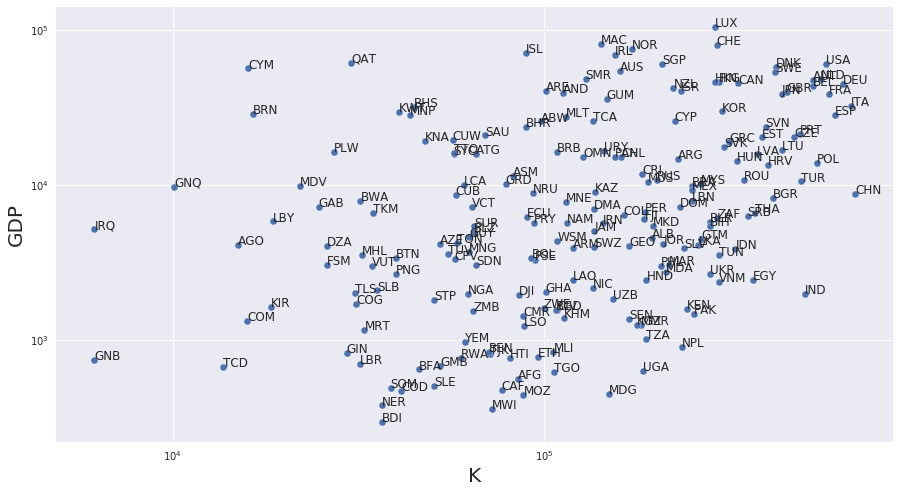

In [295]:
plt.figure(figsize=(15,8))
plt.scatter(Dfc['K'],Dfc['GDP per captital'],edgecolor='w')
plt.yscale('log')
plt.xscale('log')
Dfc1 = Dfc.dropna()
for i in Dfc1.index:
    try:
        name,x,y = Dfc1.name[i],Dfc1.K[i],Dfc1['GDP per captital'][i]
        plt.text(x,y,name)
    except:
        pass
plt.ylabel("GDP",fontsize=20)
plt.xlabel("K",fontsize=20)

In [296]:
SWcm = [[i,Cm[i]] for i in range(len(Cm))]
SWcm =  sorted(SWcm,key=lambda x:x[1],reverse=True)

In [297]:
tmp=[]
for i,k in SWcm:
    try:
        tmp.append([countryid2code[x2origin[i]],k,gdp[countryid2code[x2origin[i]]]])
    except:
        pass
Dfcm = pd.DataFrame(tmp,columns=["name",'K','GDP per captital'])
Dfcm.head()

,name,K,GDP per captital
0,SGP,1290.530788,60297.793781
1,JPN,1280.089065,38331.979398
2,HKG,1278.023671,46220.504549
3,KOR,1272.953404,29742.838861
4,MYS,1270.771680,10117.569033


Text(0.5,0,'K')

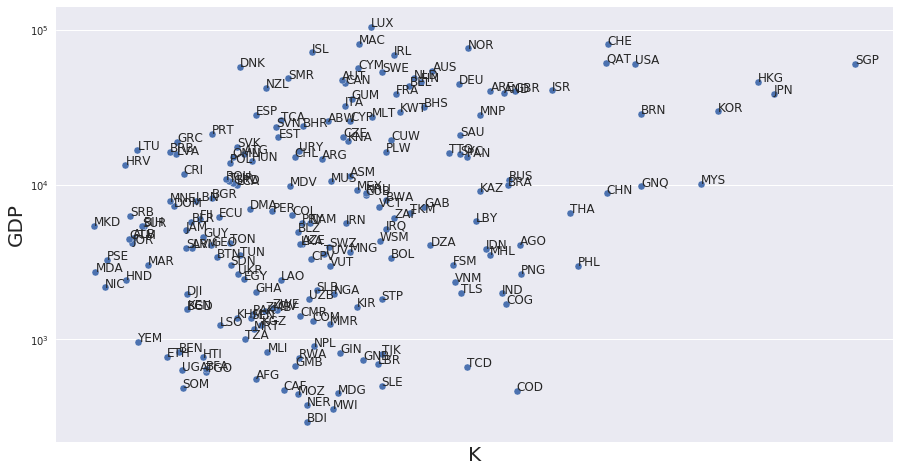

In [298]:
plt.figure(figsize=(15,8))
plt.scatter(Dfcm['K'],Dfcm['GDP per captital'],edgecolor='w')
plt.yscale('log')
plt.xscale('log')
Dfcm1 = Dfcm.dropna()
for i in Dfcm1.index:
    try:
        name,x,y = Dfcm1.name[i],Dfcm1.K[i],Dfcm1['GDP per captital'][i]
        plt.text(x,y,name)
    except:
        pass
plt.ylabel("GDP",fontsize=20)
plt.xlabel("K",fontsize=20)

In [15]:
lst = [['L0','R0'],['L0','R1'],['L1','R0'],['L1','R1'],['B0','T1'],['B0','T0'],['B1','T1'],['B1','T0'],
        ['G','L0'],['G','L1'],['G','R0'],['G','R1'],['G','B0'],['G','B1'],['G','T0'],['G','T1']]

In [11]:
id2Name=list(set([i for tmp in lst for  i in tmp]))

In [13]:
Name2id=dict(zip(id2Name,range(len(Nameid))))

In [16]:
lst1  = [[Name2id[a],Name2id[b]] for a,b in lst]

In [48]:
import scipy.sparse as sparse
x = [i for i,j in lst1]+[j for i,j in lst1]
y = [j for i,j in lst1]+[i for i,j in lst1]
from scipy import sparse
n=len(Name2id)
M = sparse.csc_matrix(([1.0]*len(x),(x,y)),shape=(n,n))
M = RCA_sparse(M)
#M0 = M.T*M
M0 = copy.deepcopy(M)
M1 = M0 / M0.sum(axis=0)

import copy 
M2=np.zeros((len(M1),len(M1)))
M3=copy.deepcopy(M1)
for k in range(2,100):
    M3 = M3*M1
    M2+=M3
M2=M2 / M2.sum(axis=0)

==Time 0.02==


/home/hachi/soft/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


In [49]:
Md = M0.todok()
index = list(dict(Md).keys())
K = [[i,j,M1[i,j]/M2[i,j]] for (i,j) in index]
SW = sorted(K,key=lambda x:x[2],reverse=True)
tmp =[]
for i,j,k in SW:
    try:
        tmp.append([id2Name[i],id2Name[j],k])
    except:
        pass
pd.DataFrame(tmp)

In [69]:
K1 = M1/M2
K=[[i,j,K1[i,j]] if M1[i,j]>0 else [i,j,-M2[i,j]] for i in range(len(M1)) for j  in range(len(M1)) if i>j]
SW = sorted(K,key=lambda x:x[2],reverse=True)
tmp =[]
for i,j,k in SW:
    try:
        tmp.append([id2Name[i],id2Name[j],k])
    except:
        pass
print(pd.DataFrame(tmp,columns=['name1','name2','ComSub']).head())
print(pd.DataFrame(tmp,columns=['name1','name2','ComSub']).tail())

  name1 name2    ComSub
0    L0    R1  3.516286
1    L0    R0  3.516286
2    L1    R1  3.516286
3    L1    R0  3.516286
4    B0    T0  3.516286
   name1 name2    ComSub
31    B1    R1 -0.092076
32    R0    R1 -0.096158
33    L1    L0 -0.096158
34    T1    T0 -0.096158
35    B1    B0 -0.096158


In [83]:
Ki = list(K1.sum(1).T.tolist()[0])
for i in range(len(Ki)):
    print(id2Name[i],Ki[i])

T0 8.367040827159418
B0 8.36704082715942
T1 8.367040827159418
R1 8.367040827159421
B1 8.36704082715942
G 10.675744680851055
R0 8.367040827159421
L0 8.367040827159421
L1 8.367040827159421


In [70]:
pd.DataFrame(tmp,columns=['name1','name2','ComSub'])

,name1,name2,ComSub
0,L0,R1,3.516286
1,L0,R0,3.516286
2,L1,R1,3.516286
3,L1,R0,3.516286
4,B0,T0,3.516286
5,T1,B0,3.516286
6,B1,T0,3.516286
7,B1,T1,3.516286
8,R0,G,1.334468
9,L0,G,1.334468
